In [9]:
import os
import struct
from PIL import Image
import numpy as np

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from preprocess import extract_images
from dataset import get_full_list, ChineseCharacterDataset
from model import VAE, vae_loss
from utils import visualize_images, show_images

In [3]:
%load_ext autoreload
%autoreload 2

### Preprocessing of dataset:

In [9]:
# Only run it once is enough !!!
gnt_dir = './dataset_gnt'
output_dir = './dataset'
extract_images(gnt_dir, output_dir)

In [20]:
# Set the directory and load the dataset
image_dir = './dataset'
full_data_list = get_full_list(image_dir)

# Create the full dataset
full_dataset = ChineseCharacterDataset(full_data_list)

# Define the subset sizes
total_size = len(full_dataset)
train_size = int(0.001 * total_size)
val_size = int(0.1 * total_size)
test_size = int(0.1 * total_size)

# Calculate the remaining size to be excluded
remaining_size = total_size - (train_size + val_size + test_size)

# Split the dataset into training, validation, test, and remaining sets
train_data_set, val_data_set, test_data_set, _ = random_split(\
    full_dataset, [train_size, val_size, test_size, remaining_size])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

# Create data loaders
train_loader = DataLoader(train_data_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data_set, batch_size=64, shuffle=False)

Training Set Size: 243
Validation Set Size: 24357
Test Set Size: 24357


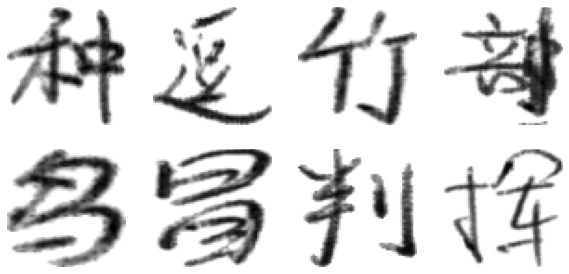

In [21]:
# Visualize images from the training set
visualize_images(train_loader, num_images=8)

### Model:

In [29]:
input_dim = 64 * 64
hidden_dim = 400
z_dim = 20
learning_rate = 1e-3
num_epochs = 20

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = VAE(input_dim, hidden_dim, z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

Using device: cuda


In [30]:
# Train
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_data_set):
        data = data.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = model(data)
        loss = vae_loss(reconstructed_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_data_set.dataset)}')

Epoch 1, Loss: 1.79013796886162
Epoch 2, Loss: 1.731772814280467
Epoch 3, Loss: 1.7323047451943754
Epoch 4, Loss: 1.7172344165728268
Epoch 5, Loss: 1.7175291680750135
Epoch 6, Loss: 1.711556727735889
Epoch 7, Loss: 1.7108374344385016
Epoch 8, Loss: 1.7072979466599905
Epoch 9, Loss: 1.703303675150148
Epoch 10, Loss: 1.6987279669230249
Epoch 11, Loss: 1.690771536195695
Epoch 12, Loss: 1.6849535691384374
Epoch 13, Loss: 1.6860830518029577
Epoch 14, Loss: 1.6821751148739514
Epoch 15, Loss: 1.6811603849787293
Epoch 16, Loss: 1.6822189133845369
Epoch 17, Loss: 1.6800025507809935
Epoch 18, Loss: 1.6758299509287486
Epoch 19, Loss: 1.6802878277160795
Epoch 20, Loss: 1.6791906778575099


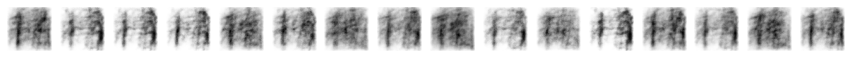

In [38]:
# Evaluate
model.eval()

# Sample and generate
with torch.no_grad():
    z = torch.randn(64, z_dim).to(device)
    sample = model.decoder(z).cpu()
    sample = sample.view(64, 1, 64, 64)

show_images(sample.numpy())